# ASSAY analysis

colaboration between damian industries and shi lab

## imports

In [1]:
# imports:
# main contains all the functions specifically for the Assay analysis
#from main import *

# matplotlib as plotting library:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#
import pprint
import pandas as pd
import numpy as np

from ipywidgets import widgets
from assaypy import *

In [2]:
plt.rcParams["figure.figsize"] = (10,8)

In [3]:
# okay lets start by choosing the excel file we want to analysis: 
assay_run_1 =  path_to_xlsx('tests/testfiles/221222 Orange and Lime Run corrected.xlsx')
print('using assays xlsx file: ',assay_run_1)

using assays xlsx file:  tests/testfiles/221222 Orange and Lime Run corrected.xlsx


In [4]:
# save all worksheets as pandas dataframes:
dfs1 = excel_to_pandas(assay_run_1)

In [5]:
print_data_structure(dfs1)

data structure with columns found:
   
Assay 1 No Shaking
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
number of columns: 30
  
Assay 2 Shaking
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
number of columns: 30
  
Assay 3 Shaking
['A9', 'A10', 'A11', 'A12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12']
number of columns: 50
  
Assay 4 Shaking
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'E1', 'E2', 'E3', 'E4', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8

## remove for analysis:
### remove whole worksheet/assay:

In [6]:
print('tick box to remove Assays:')
checkboxes = [widgets.Checkbox(value=False, description=label) for label in list(dfs1)]
display(widgets.VBox(children=checkboxes))

tick box to remove Assays:


In [7]:
remove_assays = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        remove_assays = remove_assays + [checkboxes[i].description]
for n in remove_assays:
     del dfs1[n]
print('removed assays:', remove_assays)

removed assays: []


### remove columns:

be careful, might kill dublet/triplet 

In [8]:
# del dfs1['Assay 1 No Shaking']['A2']

## attach triplet/dublet information to Assays

In [9]:
dubtrip = attach_dubtrip(dfs1)

--
Dublet/Triplet for - Assay 1 No Shaking -: 3
--
Dublet/Triplet for - Assay 2 Shaking -: 3
--
Dublet/Triplet for - Assay 3 Shaking -: 2
--
Dublet/Triplet for - Assay 4 Shaking -: 2
 
final:

{'Assay 1 No Shaking': 3,
 'Assay 2 Shaking': 3,
 'Assay 3 Shaking': 2,
 'Assay 4 Shaking': 2}


In [10]:
## only run this cell if you want to redo a specific Assay dublet/triplet:
change_assay_dubtrip(dfs1, dubtrip)

which assay do you want to change? 
 
nothing changed
still:

{'Assay 1 No Shaking': 3,
 'Assay 2 Shaking': 3,
 'Assay 3 Shaking': 2,
 'Assay 4 Shaking': 2}


## grouping wells

grouping to previous determined Dub / Trip states

In [11]:
groups = group_wells(dfs1, dubtrip)

grouping wells with provided dubtrip data:
   
{'Assay 1 No Shaking': 3,
 'Assay 2 Shaking': 3,
 'Assay 3 Shaking': 2,
 'Assay 4 Shaking': 2}
   
Assay 1 No Shaking
A1-A2-A3
A4-A5-A6
B1-B2-B3
B4-B5-B6
B7-B8-B9
B10-B11-B12
C1-C2-C3
C4-C5-C6
C7-C8-C9
C10-C11-C12
 
Assay 2 Shaking
A1-A2-A3
A4-A5-A6
B1-B2-B3
B4-B5-B6
B7-B8-B9
B10-B11-B12
C1-C2-C3
C4-C5-C6
C7-C8-C9
C10-C11-C12
 
Assay 3 Shaking
A9-A10
A11-A12
D1-D2
D3-D4
D5-D6
D7-D8
D9-D10
E1-E2
E3-E4
E5-E6
E7-E8
E9-E10
E11-E12
F1-F2
F3-F4
F5-F6
F7-F8
F9-F10
F11-F12
G1-G2
G3-G4
G5-G6
G7-G8
G9-G10
G11-G12
 
Assay 4 Shaking
D1-D2
D3-D4
D5-D6
D7-D8
D9-D10
E1-E2
E3-E4
F1-F2
F3-F4
F5-F6
F7-F8
F9-F10
F11-F12
G1-G2
 


## calculate slopes

`analyse_all(dfs1, interval = 200, time0=True)`

time0 if `True` starts slope analysis after reaction starts, takes also time in seconds

In [13]:
analyse = analyse_all(dfs1, interval = 300, time0 = True)
slopes = analyse[0]
errslo = analyse[1]

# export the analysis

In [18]:
with pd.ExcelWriter('output_slopes.xlsx') as writer:  
    for assay in list(slopes):
        slopes[assay].to_excel(writer, sheet_name=assay)

## plot slopes

dfs1 = DataFrame with all data loaded

groups = information about grouping of the data

exclude = exclude e.g. 'Assay 1 No Shaking' e.g. or 3 for exluding Triplets

`plot_assays_and_slopes(dfs1, groups, exclude = [3, 'Assay 3 Shaking'])`


replace `%matplotlib inline` with `%matplotlib widget` for interactive plot


Assay 1 No Shaking


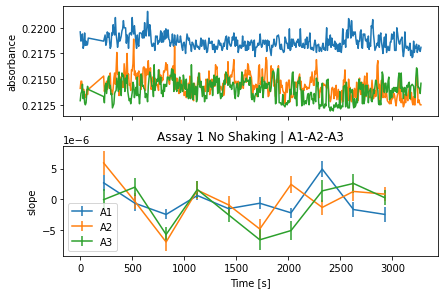

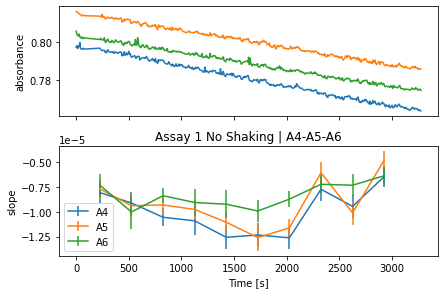

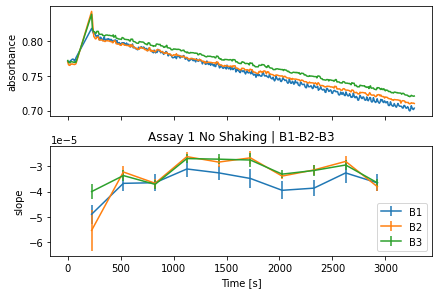

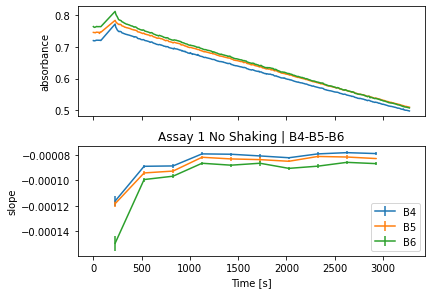

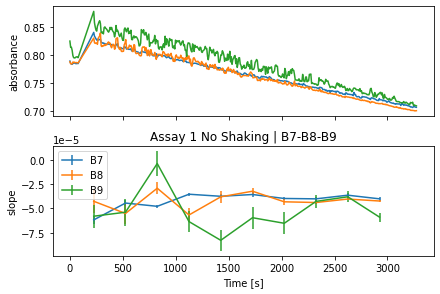

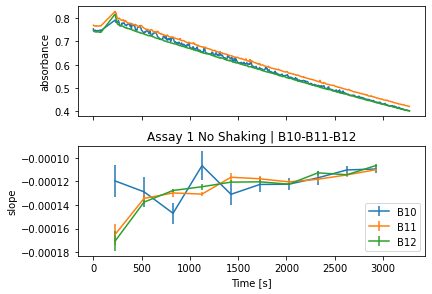

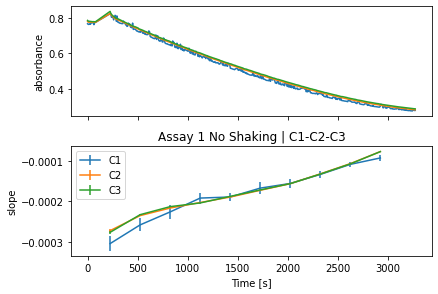

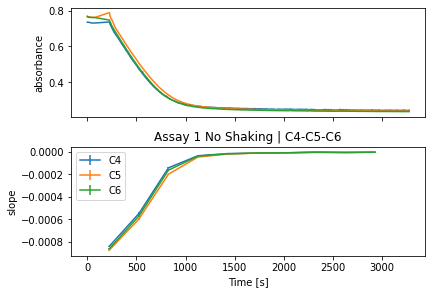

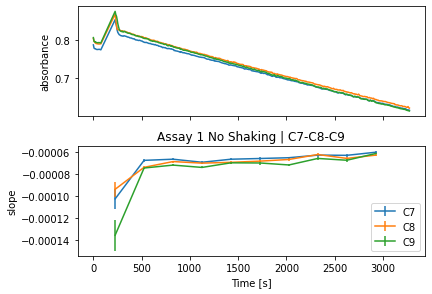

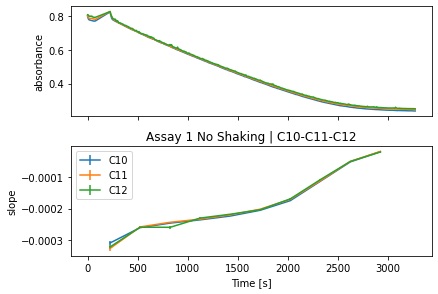

Assay 2 Shaking


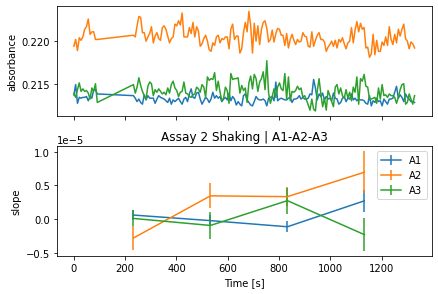

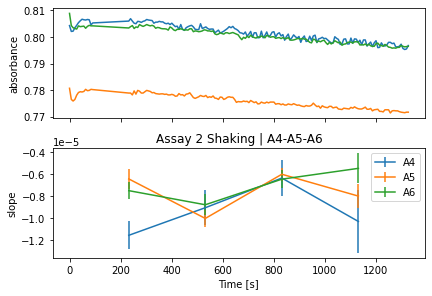

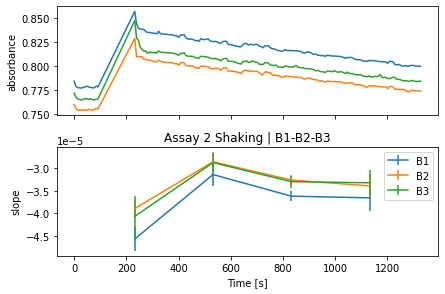

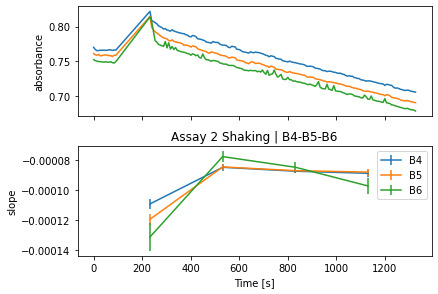

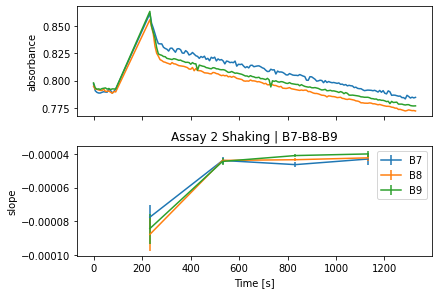

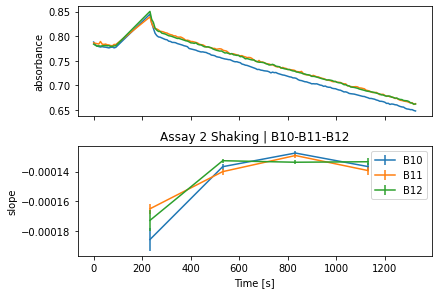

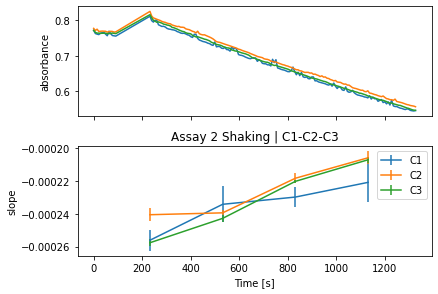

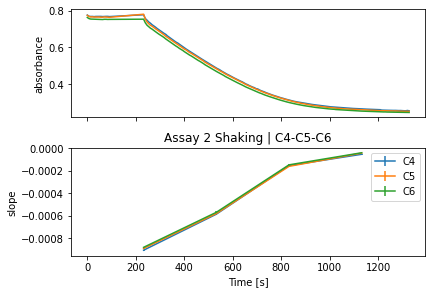

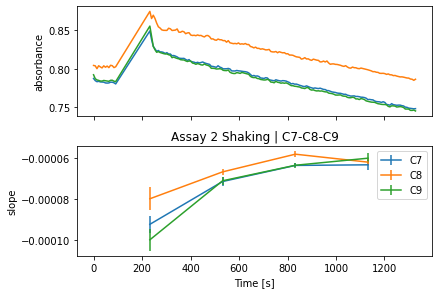

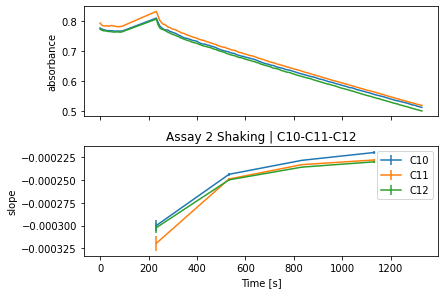

Assay 3 Shaking


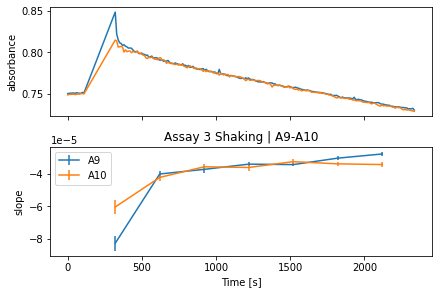

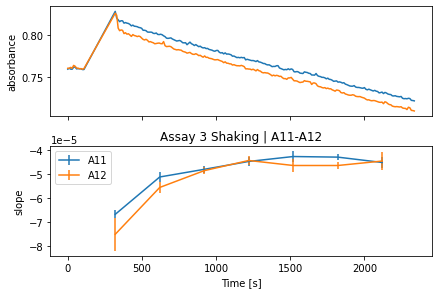

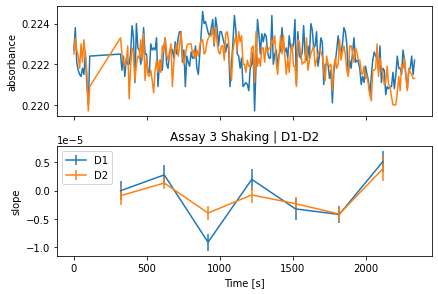

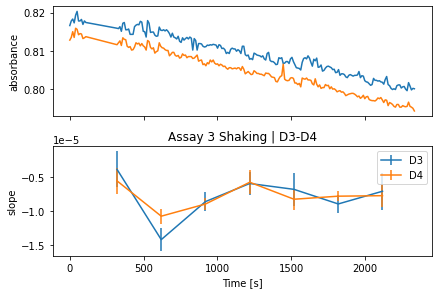

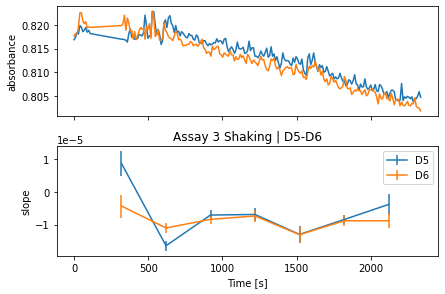

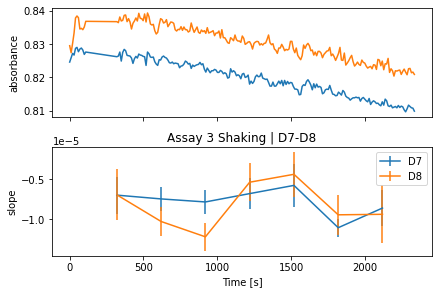

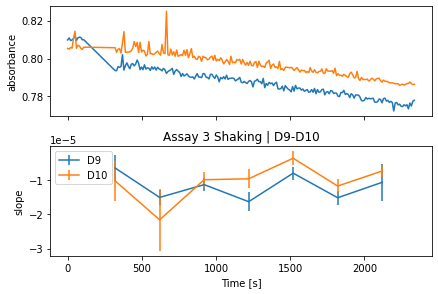

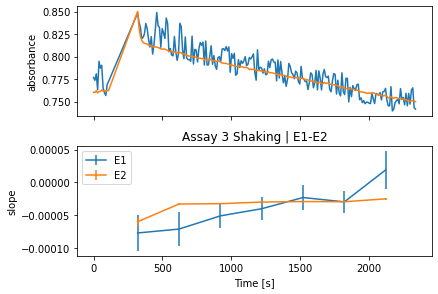

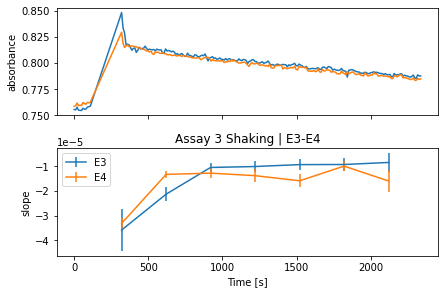

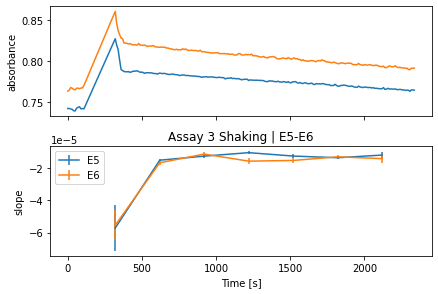

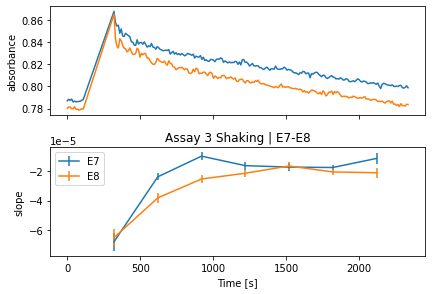

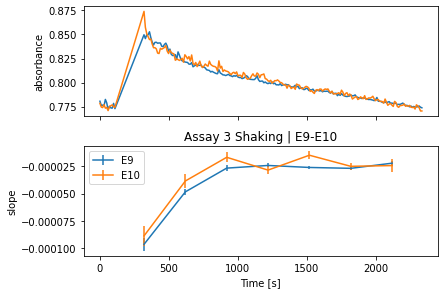

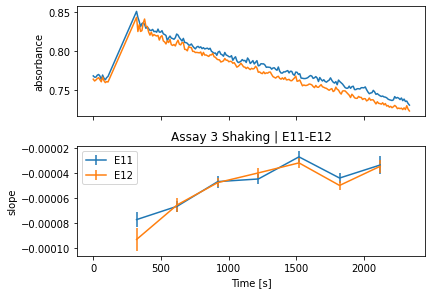

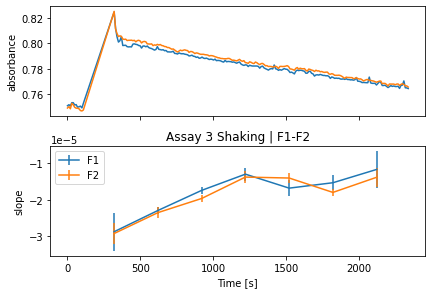

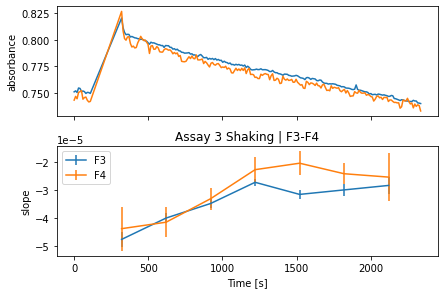

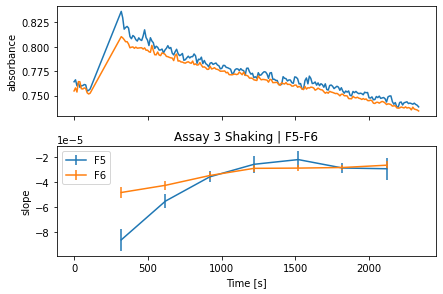

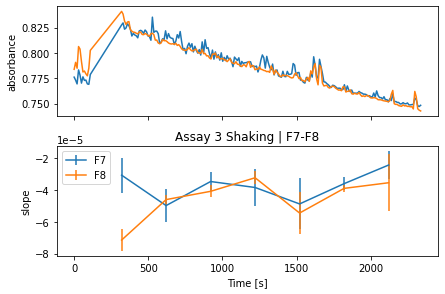

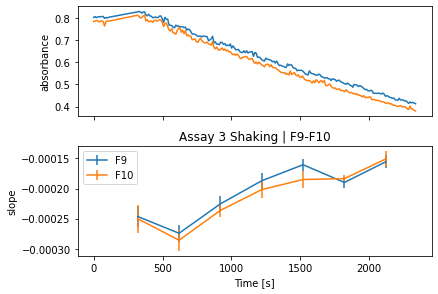

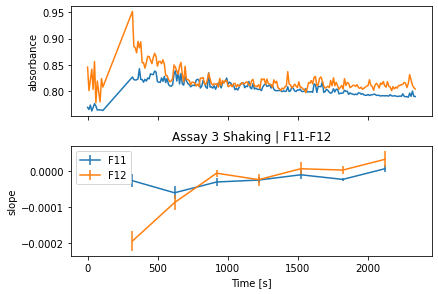

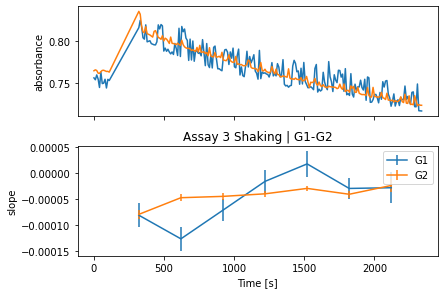

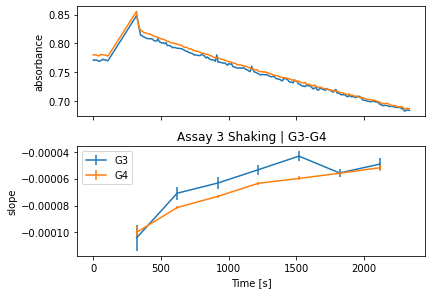

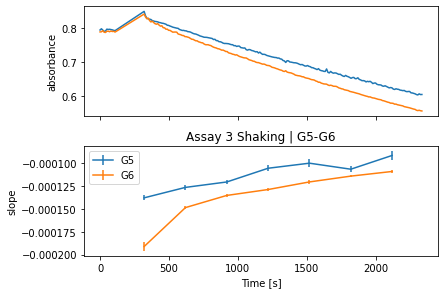

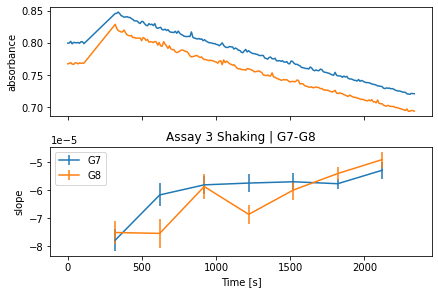

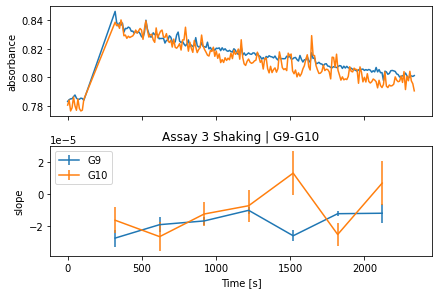

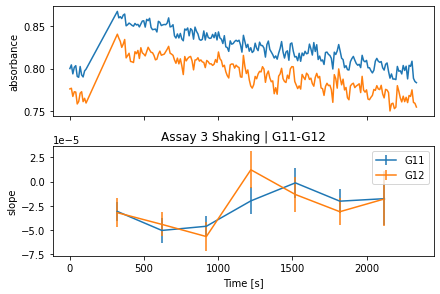

Assay 4 Shaking


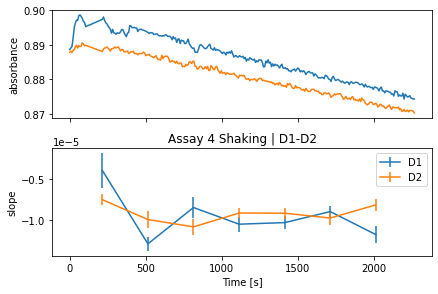

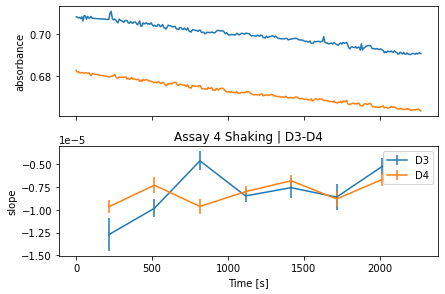

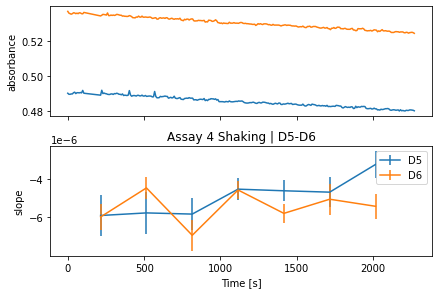

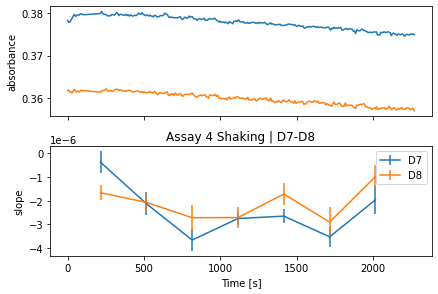

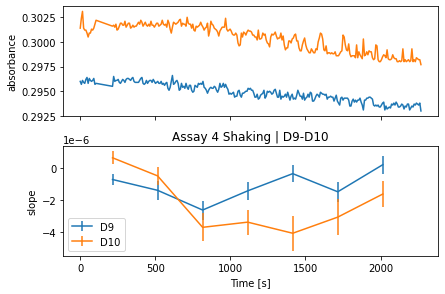

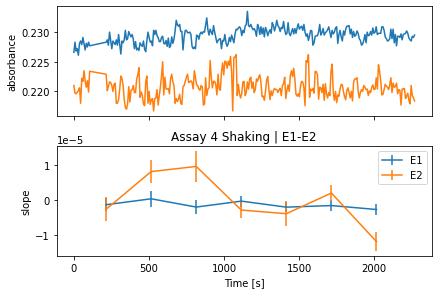

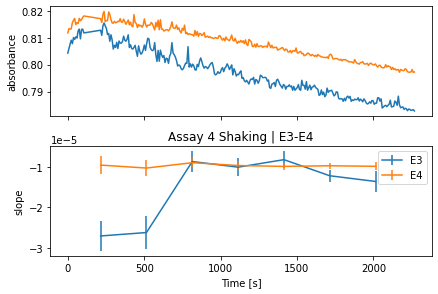

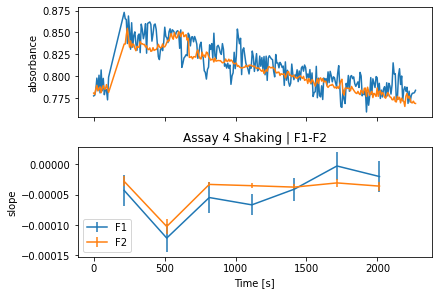

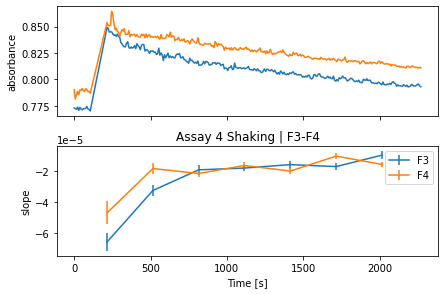

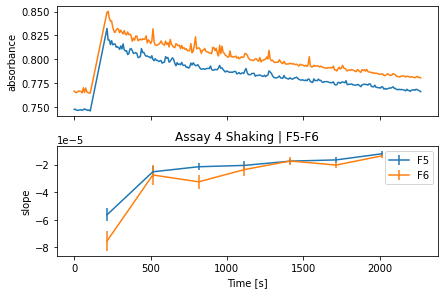

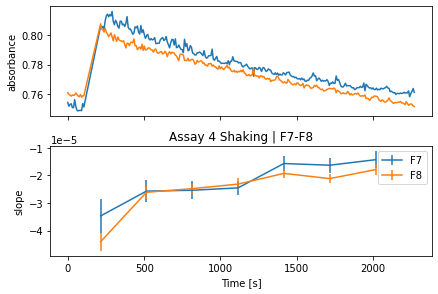

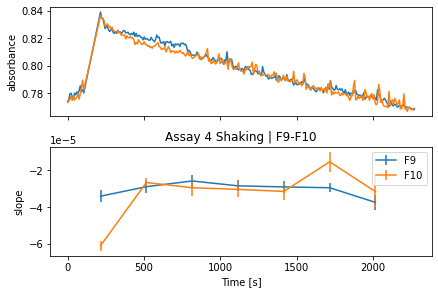

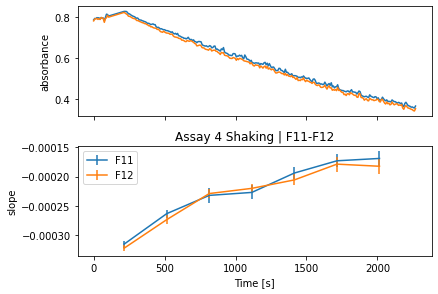

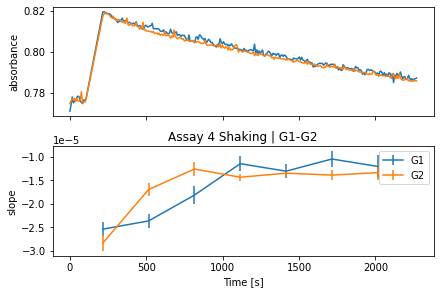

In [13]:
%matplotlib inline
plot_assays_and_slopes(dfs1, 
                       groups, 
                       slopes, 
                       errslo, 
                       exclude = [],
                       )

## attach mol information to CABP assay where n = 2

input for Mol data for each well pair

enzymes can be named, but must be unique per essay

In [14]:
## CABP Groups: 
cabp_mol = {
    'Assay 2 Shaking': {
        'Orange': {
            'A1-A2-A3': 0,
            'A4-A5-A6': .5,
            'B1-B2-B3': .15,
            'B4-B5-B6': .1,
            'B7-B8-B9': .05,
            },
    },
    
    'Assay 3 Shaking': {
        'Orange': {
            'E1-E2': 0,
            'E3-E4': .5,
            'E5-E6': .15,
            'E7-E8': .1,
            'E9-E10': .05,
            },
        'Lime': {
            'E11-E12': 0,
            'F1-F2': .0625,
            'F3-F4': .01875,
            'F5-F6': .0125,
            'F7-F8': .00625,
        },
        'SYN6301': {
            'F9-F10': 0,
            'Y1-Y2': .1,
            'G1-G2': .03,
            'G3-G4': .02,
            'G5-G6': .01,
        },
        'P_Breve': {
            'G7-G8':0,
            'G9-G10':.3,
            'G11-G12':.09,
            'A9-A10':.06,
            'A11-A12': .03,  
        },
    },
}

# duplicate list into wells: 

for assay in list(cabp_mol):
    for enzyme in list(cabp_mol[assay]):
        for wellpair in list(cabp_mol[assay][enzyme]):
            for well in wellpair.split('-'):
                cabp_mol[assay][enzyme][well] = cabp_mol[assay][enzyme][wellpair]
            if len(wellpair) > 3:
                del cabp_mol[assay][enzyme][wellpair]
            
pprint.pprint(cabp_mol, sort_dicts=False )

{'Assay 2 Shaking': {'Orange': {'A1': 0,
                                'A2': 0,
                                'A3': 0,
                                'A4': 0.5,
                                'A5': 0.5,
                                'A6': 0.5,
                                'B1': 0.15,
                                'B2': 0.15,
                                'B3': 0.15,
                                'B4': 0.1,
                                'B5': 0.1,
                                'B6': 0.1,
                                'B7': 0.05,
                                'B8': 0.05,
                                'B9': 0.05}},
 'Assay 3 Shaking': {'Orange': {'E1': 0,
                                'E2': 0,
                                'E3': 0.5,
                                'E4': 0.5,
                                'E5': 0.15,
                                'E6': 0.15,
                                'E7': 0.1,
                                'E8': 0.1,
           

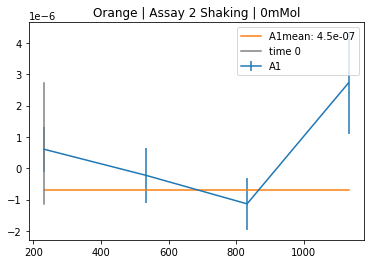

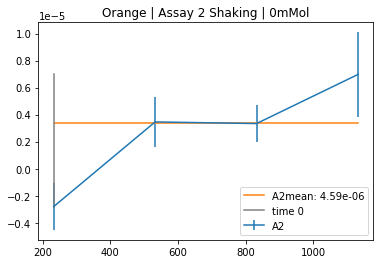

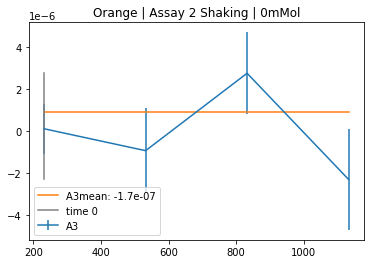

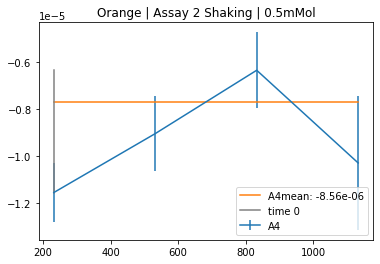

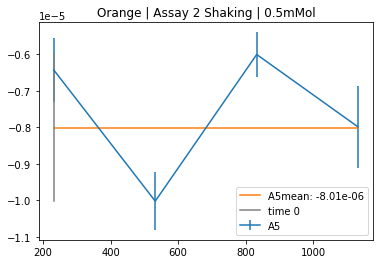

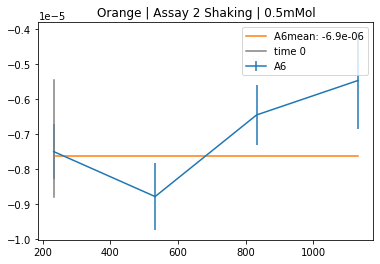

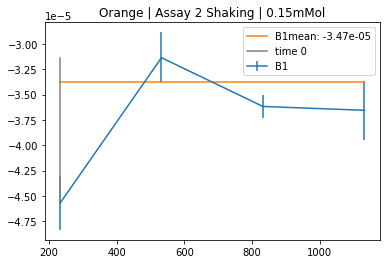

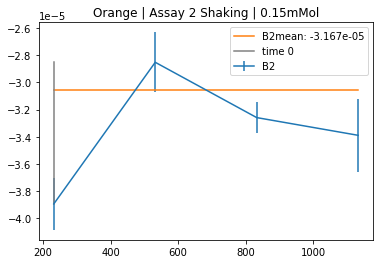

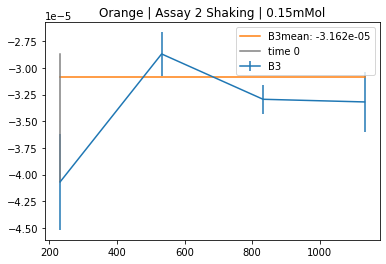

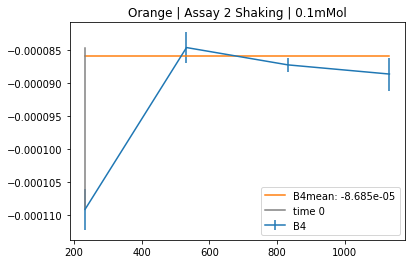

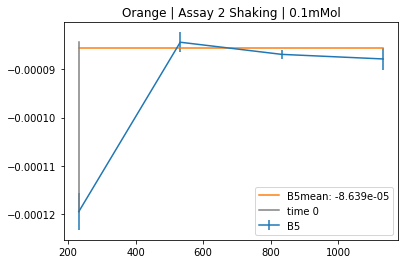

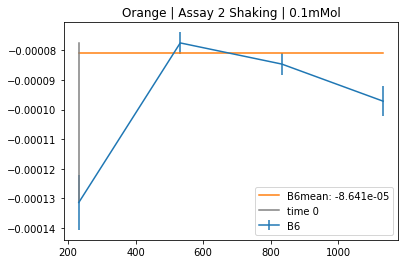

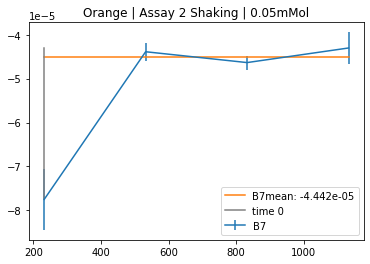

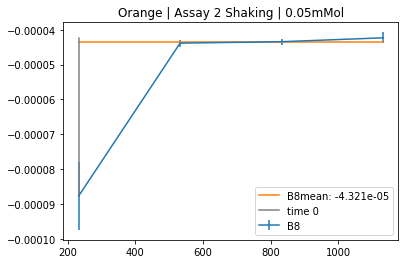

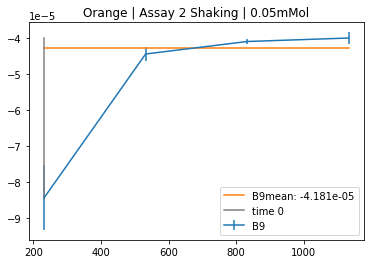

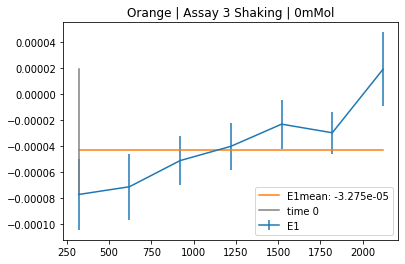

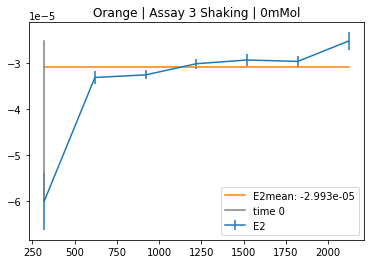

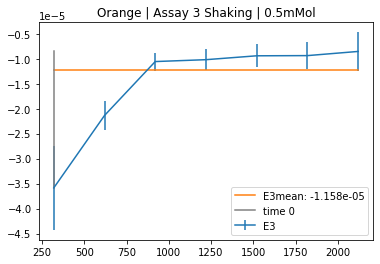

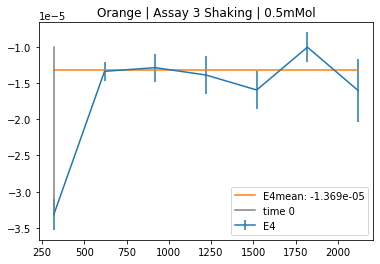

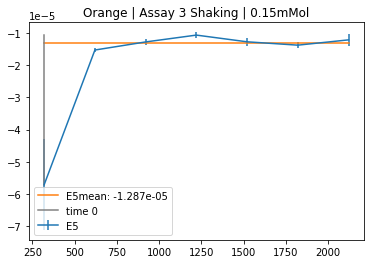

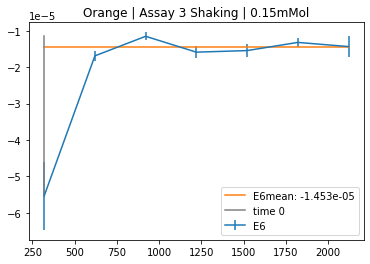

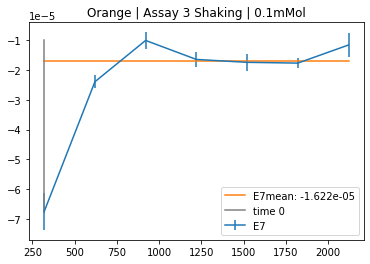

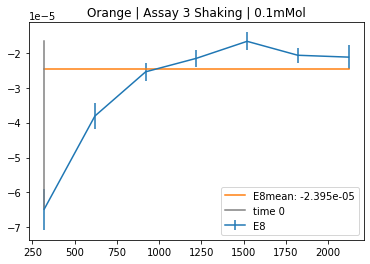

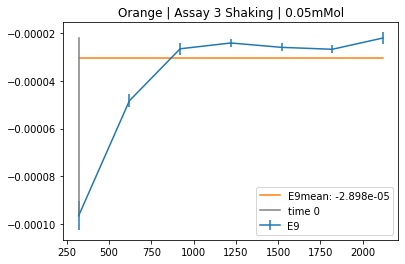

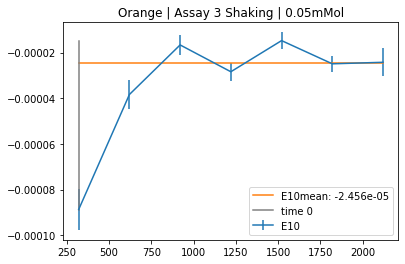

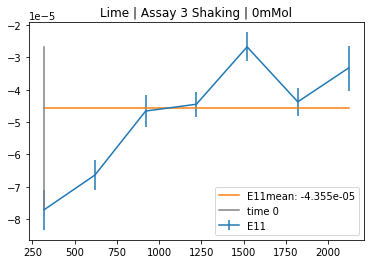

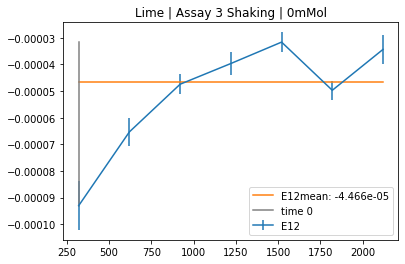

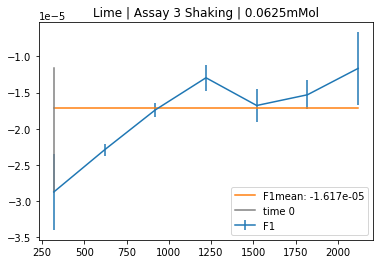

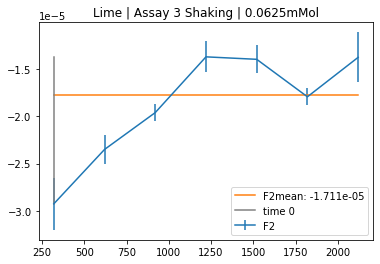

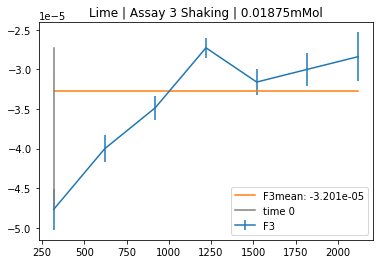

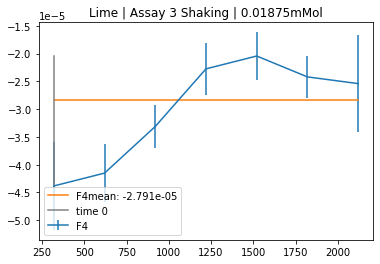

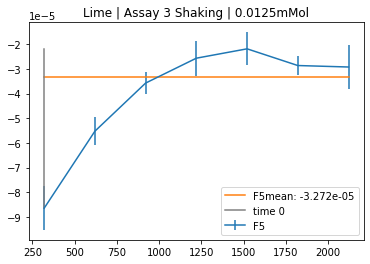

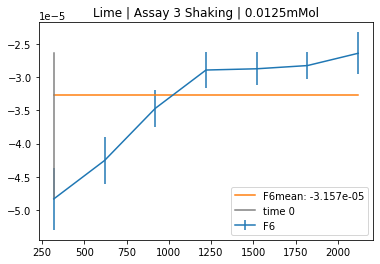

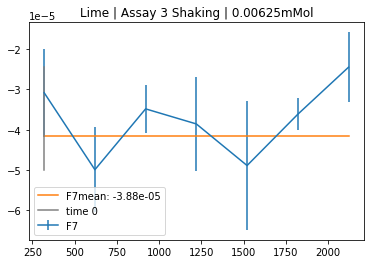

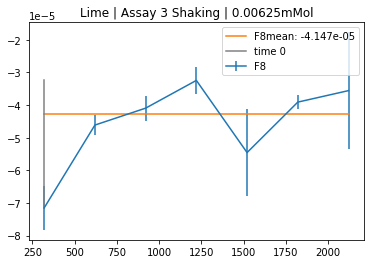

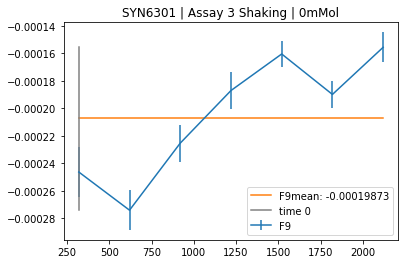

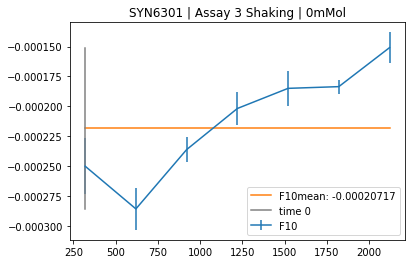

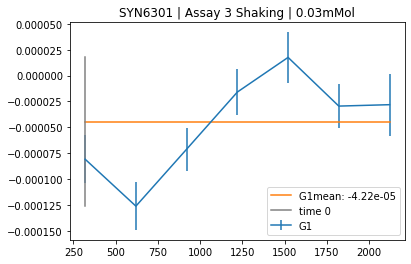

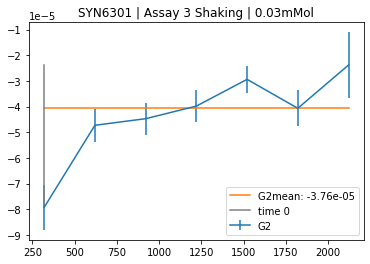

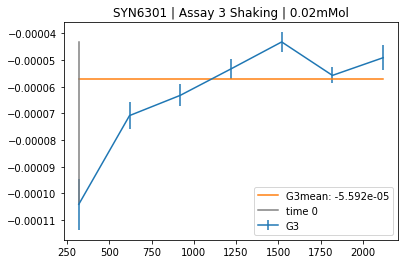

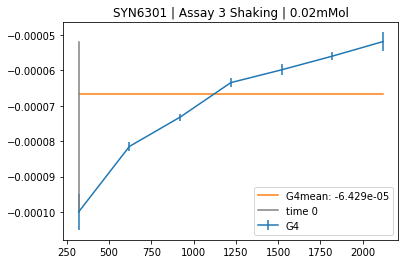

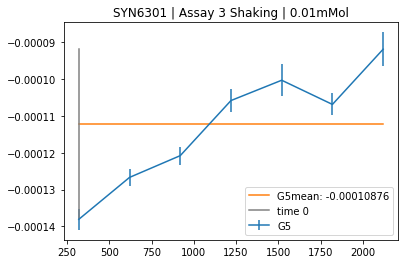

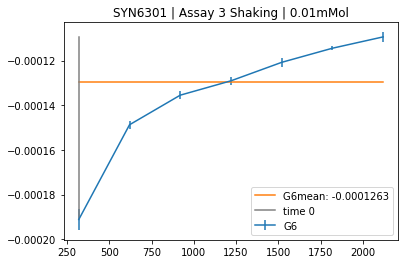

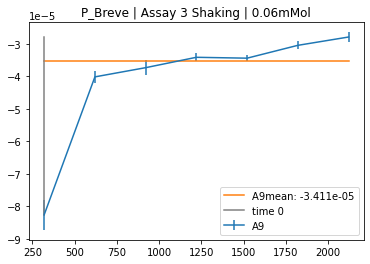

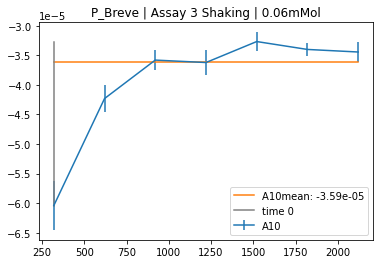

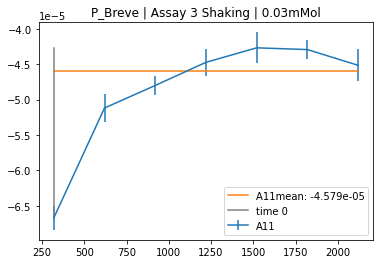

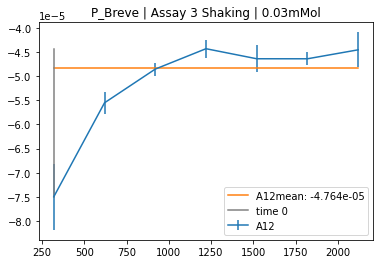

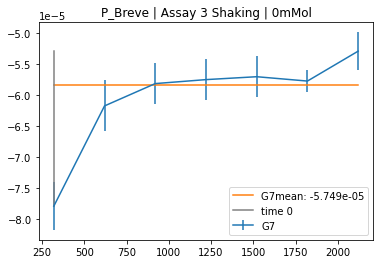

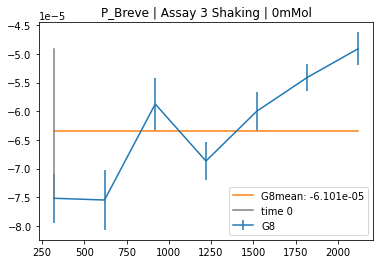

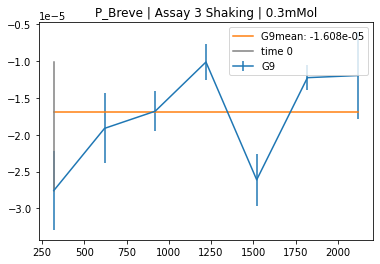

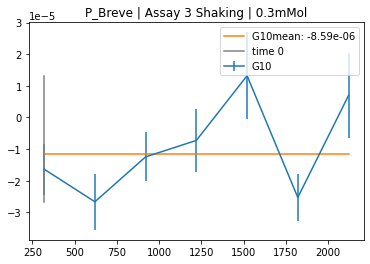

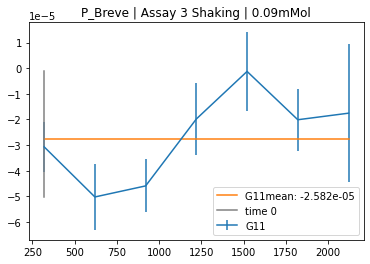

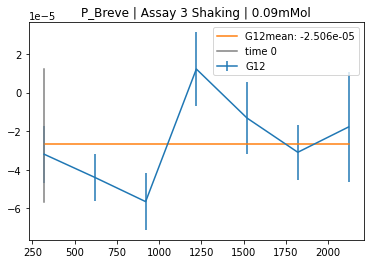

In [15]:
cabp_slopes = analyse_cabp_slopes(dfs1, 
                                  groups, 
                                  cabp_mol, 
                                  slopes, 
                                  errslo)

In [16]:
# pprint.pprint(cabp_slopes, sort_dicts=False)

In [17]:
# change slope manually:

# cabp_slopes['Assay 3 Shaking']['enzyme 1']['D7'] = (-7.046479233911714e-06, [-7.046479233911714e-06])

## plot slopes and concentrations:

exclude assays or enzymes from plotting

xintercept 0.0
rvalue^2 0.2584756310263278
baseline -7.775416446560665e-06


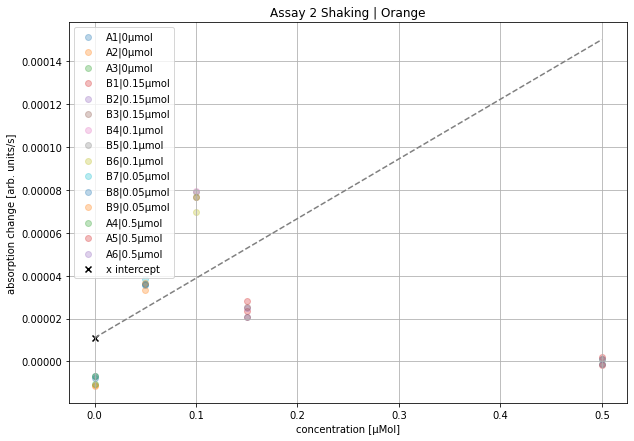

xintercept 0.15365365365365366
rvalue^2 0.8250089346930236
baseline -1.2703579063599529e-05


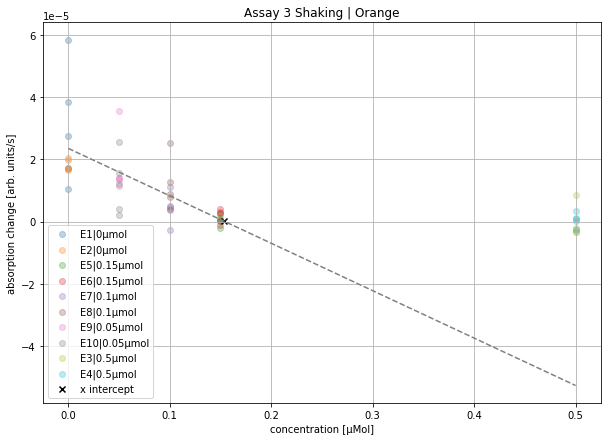

xintercept 0.032344844844844844
rvalue^2 0.9230892659287051
baseline -1.7423712728219856e-05


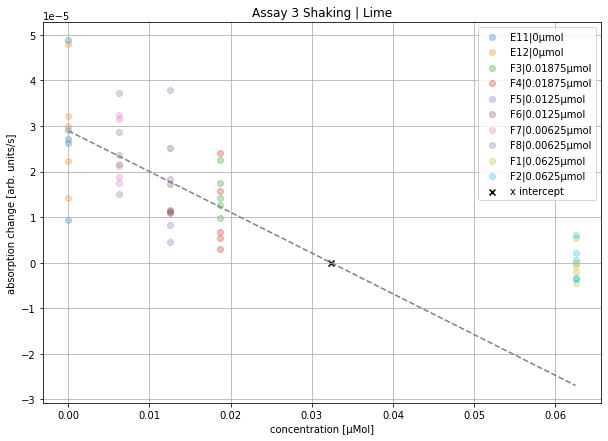

xintercept 0.021831831831831832
rvalue^2 0.9732396627148087
baseline -4.269071450042402e-05


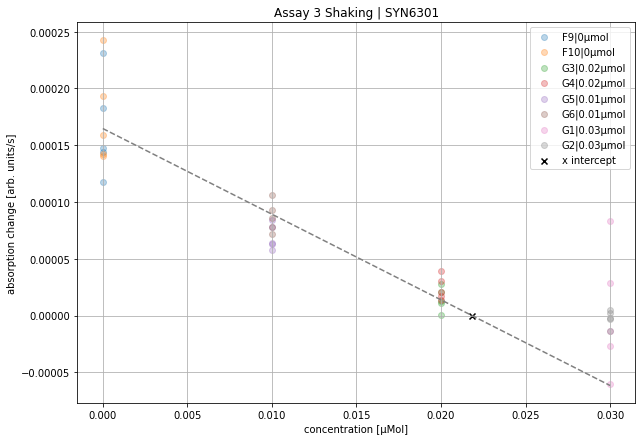

xintercept 0.12012012012012012
rvalue^2 0.9781281983980885
baseline -1.4298003979191638e-05


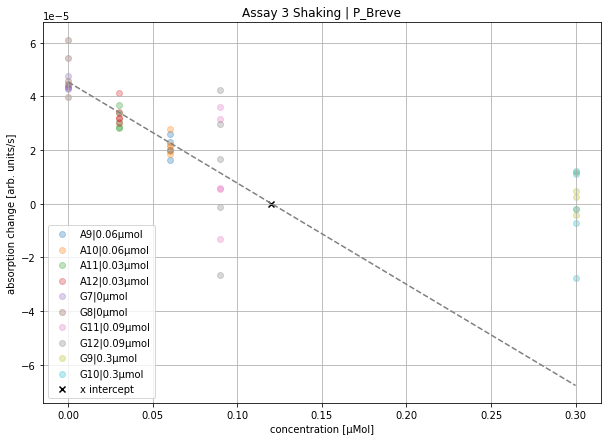

In [18]:
plot_cabp_slopes(cabp_slopes, 
                 cabp_mol, 
                 exclude = [])

# Conversion factor

$l_T$ = pathlength TECAN

$l_N$ = pathlength Nanodrop

$A_T$ = absorbance TECAN

$A_N$ = absorbance Nanodrop

$\beta$ = conversion factor between the instruments

$\beta = \frac{l_T}{l_N} = \frac{A_T}{A_N}$

In [48]:
beta = dict()
for assay in list(cabp_mol):
    beta[assay] = dict()
    change_input = input('want to use assay {}? y/n'.format(assay))
    if change_input.lower() == 'y':
        for enzyme in list(cabp_mol[assay]):
            change_input = input('want to use enzyme {}? y/n'.format(enzyme))
            _list = list()
            if change_input.lower() == 'y':
                beta[assay][enzyme] = dict()
                for well in list(cabp_mol[assay][enzyme]):
                    if cabp_mol[assay][enzyme][well] not in _list:
                        beta[assay][enzyme][well] = float(input('TECAN absorption for {} µMol | {}:\t'.format(cabp_mol[assay][enzyme][well], well)))
                        _list.append(cabp_mol[assay][enzyme][well])
            else:
                pass
    else:
        pass

want to use assay Assay 3 Shaking? y/ny
want to use enzyme Orange? y/ny
TECAN absorption for 0 µMol | E1:	1
TECAN absorption for 0.5 µMol | E3:	2
TECAN absorption for 0.15 µMol | E5:	1
TECAN absorption for 0.1 µMol | E7:	2
TECAN absorption for 0.05 µMol | E9:	1
want to use enzyme Lime? y/n
want to use enzyme SYN6301? y/n
want to use enzyme P_Breve? y/n


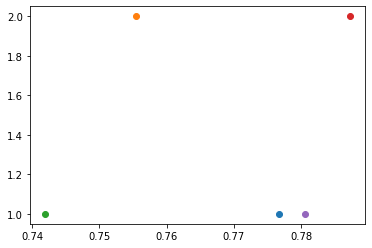

In [51]:
for assay in list(beta):
    for enzyme in list(beta[assay]):
        for well in list(beta[assay][enzyme]):
            plt.scatter(dfs1[assay][well][0], beta[assay][enzyme][well])

# def plot_cabp_conversion(dfs):
    

# Closer look on the triplets data

In [ ]:
trip_mol = {
    
    
}

# TODO


-  [ ] do triplets
- [ ] conversion factor calculation by matching the same concentration on the NADH nanodrop machine: